## CNN for MNIST Digit Classification


### 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


### 2. Device setup

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


Using device: cuda


In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: NVIDIA GeForce RTX 2050


### 3. Load MNIST dataset

In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)


### 4. Define CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)            # Input : 1 channel (grayscale), Output: 16 channels, Kernel size: 3x3 ; total 160 parameters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)           # Input : 16 channels, Output: 32 channels, Kernel size: 3x3 ; total 4640 parameters
        self.pool = nn.MaxPool2d(2, 2)                          # Input : 32 channels, Output: 32 channels, Kernel size: 2x2 ; total 0 parameters, reduces size by half
        
        self.fc1 = nn.Linear(32 * 5 * 5, 128)                   # [32*5*5 inputs and 128 output neurons] Converts 2D feature maps to 1D vector; total 128 * (32*5*5) + 128 = 102,528 parameters
        self.fc2 = nn.Linear(128, 10)                           # (128 input, 10 output neurons) Output layer for 10 classes; total 128 * 10 + 10 = 1,290 parameters

    def forward(self, x):
        x = torch.relu(self.conv1(x))                           # size: (batch_size, 16, 26, 26)
        x = self.pool(x)                                        # size: (batch_size, 16, 13, 13)
        
        x = torch.relu(self.conv2(x))                           # size: (batch_size, 32, 11, 11)
        x = self.pool(x)                                        # size: (batch_size, 32, 5, 5)
        
        x = x.view(x.size(0), -1)                               # flatten the output of the convolutional layer from a 3D feature map to a 1D vector (size: (batch_size, 32*5*5)) beacuse the fully connected layer (nn.Linear) expects a 1D input
        
        x = torch.relu(self.fc1(x))                             # size: (32*5*5 inputs, 128 output neurons) [no activation function applied to the output layer]
        x = self.fc2(x)                                         # size: (128 input, 10 output neurons)
        
        return x                                                


#### COMPLETE EXPLANATION: Advanced CNN for MNIST
```
PART 1: CLASS DEFINITION

PART 2: FIRST CONVOLUTIONAL LAYER
self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  [conv2d means 2D convolutional layer]
Parameters:
1: Input channels (1 for grayscale MNIST)
16: Output channels (16 filters)
kernel_size=3: Each filter is 3×3 pixels
What it creates:
16 filters of size 3×3 → 16 × 9 = 144 weights
16 bias values (one per filter)
Total: 160 parameters
Output shape: (batch_size, 16, 26, 26) [after 1st cnnvolution] [output_size = (input_size - kernel_size + 1)]
Input: 28×28 → After conv (no padding): 26×26 (size)

PART 3: SECOND CONVOLUTIONAL LAYER
self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
Parameters:
16: Input channels (from previous layer's output)
32: Output channels (32 filters)
kernel_size=3: Each filter is 3×3
What it creates:
32 filters of size 3×3 × 16 input channels = 32 × 3×3×16 = 4,608 weights
32 bias values
Total: 4,640 parameters
Output shape:

PART 4: POOLING LAYER
self.pool = nn.MaxPool2d(2, 2)
Parameters:
2: Kernel size (2×2 window)
2: Stride (move by 2 pixels each step)
What it does:
Takes each 2×2 region and keeps only the maximum value
Reduces height and width by half
No learnable parameters

PART 5: FULLY CONNECTED LAYERS  [32*5*5 inputs and 128 output neurons]
self.fc1 = nn.Linear(32 * 5 * 5, 128)
Why 32 * 5 * 5? Let's trace the size reduction:
Input: 28×28
↓ conv1 (3×3, no pad): 26×26
↓ pool (2×2): 13×13
↓ conv2 (3×3, no pad): 11×11
↓ pool (2×2): 5×5
↓ 32 channels

Final feature map: 32 × 5 × 5 = 800 features
Parameters:
Input features: 800
Output features: 128
Weights: 800 × 128 = 102,400
Biases: 128
Total: 102,528 parameters

self.fc2 = nn.Linear(128, 10)  (128 input, 10 output neurons)
Parameters:
Input: 128 features
Output: 10 classes (digits 0-9)
Weights: 128 × 10 = 1,280
Biases: 10
Total: 1,290 parameters


PART 6: FORWARD PASS

def forward(self, x):
    x = torch.relu(self.conv1(x))
Step 1: Apply first convolution + ReLU
Input shape: (batch, 1, 28, 28)
Output shape: (batch, 16, 26, 26)

    x = self.pool(x)
Step 2: Max pooling
Input shape: (batch, 16, 26, 26)
Output shape: (batch, 16, 13, 13)


    x = torch.relu(self.conv2(x))
Step 3: Apply second convolution + ReLU
Input shape: (batch, 16, 13, 13)
Output shape: (batch, 32, 11, 11)


    x = self.pool(x)
Step 4: Max pooling again
Input shape: (batch, 32, 11, 11)
Output shape: (batch, 32, 5, 5)


    x = x.view(x.size(0), -1)   [3D feature map to 1D vector]
Step 5: Flatten
x.size(0) = batch size
-1 = automatically calculate remaining dimensions
Input shape: (batch, 32, 5, 5)
Output shape: (batch, 800)  

    x = torch.relu(self.fc1(x))
Step 6: First fully connected layer + ReLU
Input shape: (batch, 800)
Output shape: (batch, 128)


    x = self.fc2(x)
    return x
Step 7: Output layer (no activation here, will be in loss function)

Input shape: (batch, 128)

Output shape: (batch, 10) → raw logits for each digit

COMPLETE ARCHITECTURE SUMMARY

Layer                    Output Shape        Parameters
────────────────────────────────────────────────────────
Input                    (batch, 1, 28, 28)  0
│
Conv2d (1→16, 3×3)       (batch, 16, 26, 26) 160
ReLU                     (batch, 16, 26, 26) 0
│
MaxPool2d (2×2)          (batch, 16, 13, 13) 0
│
Conv2d (16→32, 3×3)      (batch, 32, 11, 11) 4,640
ReLU                     (batch, 32, 11, 11) 0
│
MaxPool2d (2×2)          (batch, 32, 5, 5)   0
│
Flatten                  (batch, 800)        0
│
Linear (800→128)         (batch, 128)        102,528
ReLU                     (batch, 128)        0
│
Linear (128→10)          (batch, 10)         1,290
│
Output                   (batch, 10)
────────────────────────────────────────────────────────
Total Parameters: 108,618
KEY DIFFERENCES FROM PREVIOUS SIMPLE CNN

Feature           	Previous CNN           	This CNN               	Benefit
Conv layers	           1 layer          	2 layers	            Learns hierarchical features
Filters	                16	                 16 → 32	            More features deeper in network
Pooling	                Once	             Twice	                More size reduction
FC layers	          1 layer            	2 layers              	More capacity for classification
Parameters          	27,210          	108,618	More            expressive power
```

### 5. Initialize model

In [ ]:
model = SimpleCNN().to(device)                               # Move the model to the GPU if available, Create an instance of the SimpleCNN class
criterion = nn.CrossEntropyLoss()                            # loss function ; Probabilities -> Avg. Loss  
optimizer = optim.Adam(model.parameters(), lr=0.001)         # optimizer ; Avg. Loss -> Gradients -> Weights


### 6. Training loop

In [8]:
epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}")


Epoch 1, Loss: 212.696
Epoch 2, Loss: 56.361
Epoch 3, Loss: 39.772


### 7. Test accuracy

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)                        # predicted index of the maximum logit (class with the highest score) for each image in the batch
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.90%


### 8. Show sample predictions

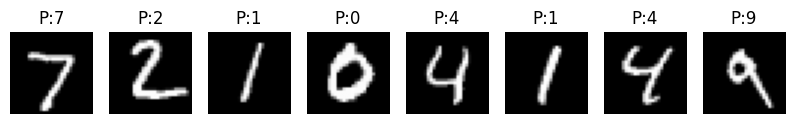

In [ ]:
images, labels = next(iter(testloader))                          # Get a batch of test images and labels from the test dataloader, calls each batch sequesntially, of 64 images and labels, but we will only use the first 8 for visualization
images = images[:8]                                              # Get the first 8 images from 1st batch of 64 images
labels = labels[:8]                                      

outputs = model(images.to(device))                               # Get the model's predictions for the 8 images, outputs will be of size (8, 10) where each row contains the logits for the 10 classes for each image
_, predicted = torch.max(outputs, 1)                             # predicted index of the maximum logit (class with the highest score) for each image in the batch

images = images.cpu()                                            # Move the images back to the CPU for visualization, since matplotlib cannot display tensors on the GPU

plt.figure(figsize=(10,4))                                       # Set the figure size for the plot (10 inches wide, 4 inches high)
for i in range(8):                                               # Iterate over the first 8 images
    plt.subplot(1,8,i+1)                                         # Create a subplot for each image (1 row, 8 columns, current index i+1)
    plt.imshow(images[i][0], cmap='gray')                        # Display the image in grayscale (images[i][0] because the images are in the format (batch_size, channels, height, width) and we want to display the first channel which is the grayscale image) here images[i][0] is the 2D array representing the pixel values of the image where is the index of the image in the batch and [0] is the channel index for grayscale images and camap (colormap)='gray' is used to display the image in grayscale 
    plt.title(f"P:{predicted[i].item()}")                        # Set the title of each subplot to show the predicted class index (predicted[i].item() converts the tensor to a Python scalar)
    plt.axis('off')                                              # Hide the axis for a cleaner look
plt.show()                                                       
